In [3]:
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import pandas as pd
import numpy as np
import random as rnd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import StandardScaler
from numpy import genfromtxt
from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score , average_precision_score
from sklearn.metrics import precision_score, precision_recall_curve
%matplotlib inline
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
init_notebook_mode(connected=True)
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

In [4]:
train_df = pd.read_csv("creditcard.csv")
print(train_df.columns.values)

['Time' 'V1' 'V2' 'V3' 'V4' 'V5' 'V6' 'V7' 'V8' 'V9' 'V10' 'V11' 'V12'
 'V13' 'V14' 'V15' 'V16' 'V17' 'V18' 'V19' 'V20' 'V21' 'V22' 'V23' 'V24'
 'V25' 'V26' 'V27' 'V28' 'Amount' 'Class']


In [5]:
train_df.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
x = train_df['Class'].value_counts().index
y = train_df['Class'].value_counts().values

trace2 = go.Bar(
     x=x ,
     y=y,
     marker=dict(
         color=y,
         colorscale = 'Viridis',
         reversescale = True
     ),
     name="Imbalance",    
 )
layout = dict(
     title="Data imbalance",
     #width = 900, height = 500,
     xaxis=go.layout.XAxis(
     automargin=True),
     yaxis=dict(
         showgrid=False,
         showline=False,
         showticklabels=True,
 #         domain=[0, 0.85],
     ), 
)
fig1 = go.Figure(data=[trace2], layout=layout)
iplot(fig1)

Classes: 1 is anomalous and 0 is normal.

In [7]:
print("Percentage of anomalous: {0:.3f}%".format(y[1]/(y[0]+y[1]) * 100))

Percentage of anomalous: 0.173%


This data is higly imballaced with regards to the classes. Anomanly detection would be the ideal way to build a classifier using this data.



In [8]:
def estimateGaussian(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.cov(dataset.T)
    return mu, sigma

def multivariateGaussian(dataset,mu,sigma):
    p = multivariate_normal(mean=mu, cov=sigma)
    return p.pdf(dataset)

In [9]:
def selectThresholdByCV(probs,gt):
    best_epsilon = 0
    best_f1 = 0
    f = 0
    farray = []
    Recallarray = []
    Precisionarray = []
    epsilons = (0.0000e+00, 1.0527717316e-70, 1.0527717316e-50, 1.0527717316e-24)
    #epsilons = np.asarray(epsilons)
    for epsilon in epsilons:
        predictions = (p_cv < epsilon)
        f = f1_score(train_cv_y, predictions, average = "binary")
        Recall = recall_score(train_cv_y, predictions, average = "binary")
        Precision = precision_score(train_cv_y, predictions, average = "binary")
        farray.append(f)
        Recallarray.append(Recall)
        Precisionarray.append(Precision)
        print ('For below Epsilon')
        print(epsilon)
        print ('F1 score , Recall and Precision are as below')
        print ('Best F1 Score %f' %f)
        print ('Best Recall Score %f' %Recall)
        print ('Best Precision Score %f' %Precision)
        print ('-'*40)
        if f > best_f1:
            best_f1 = f
            best_recall = Recall
            best_precision = Precision
            best_epsilon = epsilon    
    fig = plt.figure()
    ax = fig.add_axes([0.1, 0.5, 0.7, 0.3])
    #plt.subplot(3,1,1)
    plt.plot(farray ,"ro")
    plt.plot(farray)
    ax.set_xticks(range(5))
    ax.set_xticklabels(epsilons,rotation = 60 ,fontsize = 'medium' )
    ax.set_ylim((0,1.0))
    ax.set_title('F1 score vs Epsilon value')
    ax.annotate('Best F1 Score', xy=(best_epsilon,best_f1), xytext=(best_epsilon,best_f1))
    plt.xlabel("Epsilon value") 
    plt.ylabel("F1 Score") 
    plt.show()
    fig = plt.figure()
    ax = fig.add_axes([0.1, 0.5, 0.9, 0.3])
    #plt.subplot(3,1,2)
    plt.plot(Recallarray ,"ro")
    plt.plot(Recallarray)
    ax.set_xticks(range(5))
    ax.set_xticklabels(epsilons,rotation = 60 ,fontsize = 'medium' )
    ax.set_ylim((0,1.0))
    ax.set_title('Recall vs Epsilon value')
    ax.annotate('Best Recall Score', xy=(best_epsilon,best_recall), xytext=(best_epsilon,best_recall))
    plt.xlabel("Epsilon value") 
    plt.ylabel("Recall Score") 
    plt.show()
    fig = plt.figure()
    ax = fig.add_axes([0.1, 0.5, 0.9, 0.3])
    #plt.subplot(3,1,3)
    plt.plot(Precisionarray ,"ro")
    plt.plot(Precisionarray)
    ax.set_xticks(range(5))
    ax.set_xticklabels(epsilons,rotation = 60 ,fontsize = 'medium' )
    ax.set_ylim((0,1.0))
    ax.set_title('Precision vs Epsilon value')
    ax.annotate('Best Precision Score', xy=(best_epsilon,best_precision), xytext=(best_epsilon,best_precision))
    plt.xlabel("Epsilon value") 
    plt.ylabel("Precision Score") 
    plt.show()
    return best_f1, best_epsilon

# Feature Analysis

In [10]:
v_features = train_df.iloc[:,0:30].columns

In [11]:
v_features

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')

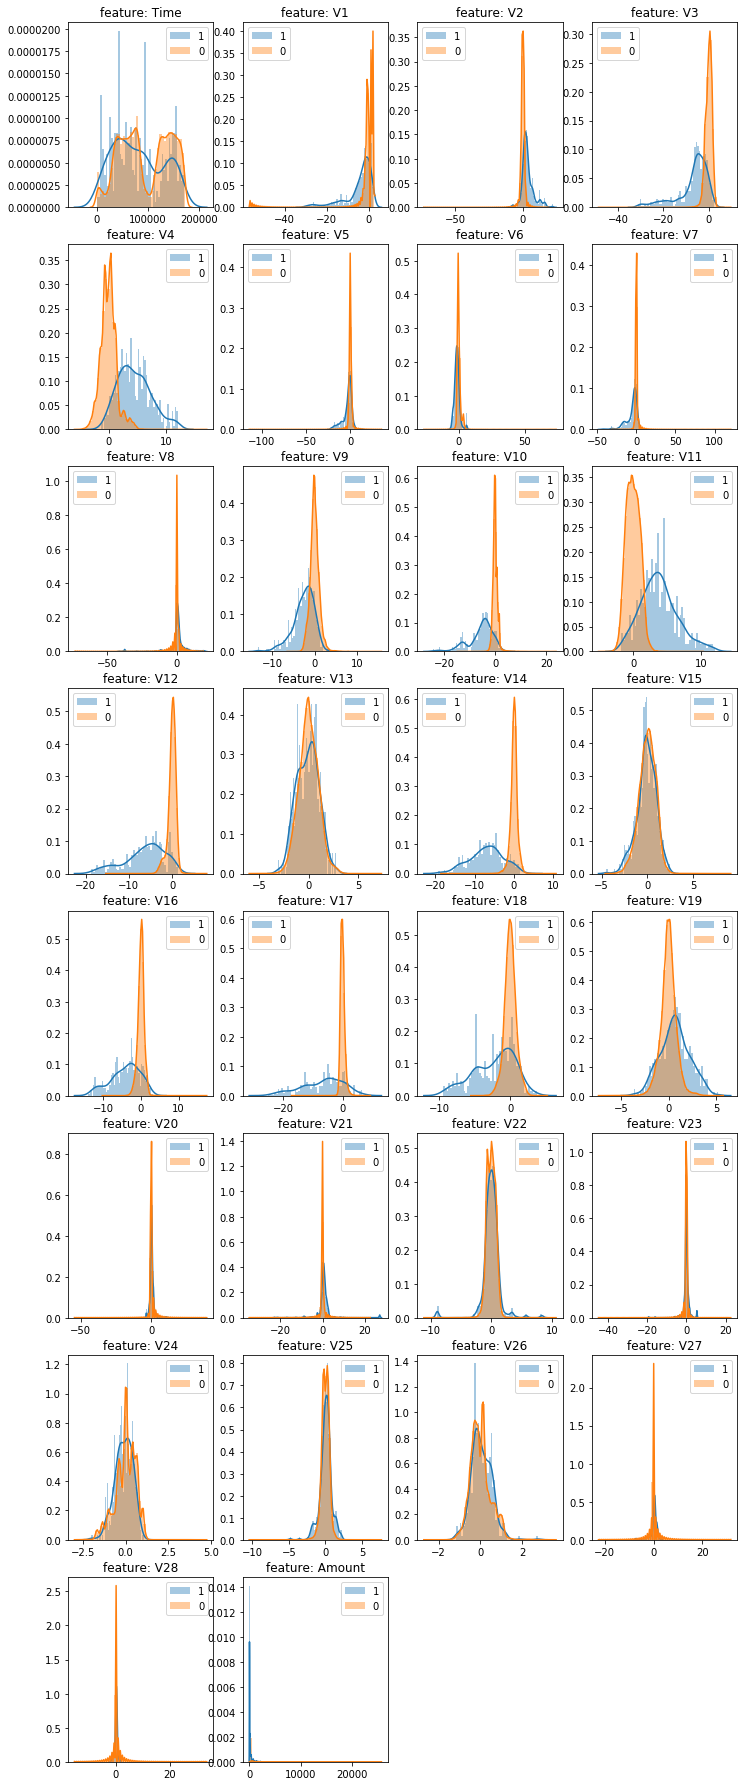

In [12]:
plt.figure(figsize=(12,8*4))
gs = gridspec.GridSpec(8, 4)
for i, cn in enumerate(train_df[v_features]):
    ax = plt.subplot(gs[i])
    sns.distplot(train_df[cn][train_df.Class == 1], bins=50, label='1')
    sns.distplot(train_df[cn][train_df.Class == 0], bins=50, label='0')
    ax.set_xlabel('')
    ax.set_title('feature: ' + str(cn))
    plt.legend()
plt.show()

In [13]:
rnd_clf = RandomForestClassifier(n_estimators = 100 , criterion = 'entropy',random_state = 0)
rnd_clf.fit(train_df.iloc[:,0:30],train_df.iloc[:,30]);

In [14]:
rnd_clf.feature_importances_

array([0.00779213, 0.00922483, 0.01258748, 0.02937246, 0.03909339,
       0.01158125, 0.01396351, 0.02267   , 0.01232533, 0.02711836,
       0.13176351, 0.07152986, 0.10011273, 0.00841788, 0.17651833,
       0.00724526, 0.05840349, 0.12571942, 0.02614881, 0.01204436,
       0.01105249, 0.01654354, 0.00709268, 0.00659453, 0.00627645,
       0.00710641, 0.01228562, 0.00965936, 0.00841443, 0.01134208])

In [15]:
train_df.iloc[:,0:30].columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')

In [16]:
x, y = (list(x) for x in zip(*sorted(zip(rnd_clf.feature_importances_, train_df.iloc[:,0:30].columns), 
                                                            reverse = False)))
trace2 = go.Bar(
    x=x ,
    y=y,
    marker=dict(
        color=x,
        colorscale = 'Viridis',
        reversescale = True
    ),
    name='Random Forest Feature importance',
    orientation='h',
)

layout = dict(
    title='Barplot of Feature importances',
     width = 600, height = 1000,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
#         domain=[0, 0.85],
    ),
    margin=dict(
    l=300,
),
)

fig1 = go.Figure(data=[trace2], layout=layout)
iplot(fig1)

In [17]:
important_features = list()

for name, importance in zip(train_df.iloc[:,0:30].columns, rnd_clf.feature_importances_):
    if importance > 0.020 :
        print('"' + name + '"'+',')
        important_features.append(name)

"V3",
"V4",
"V7",
"V9",
"V10",
"V11",
"V12",
"V14",
"V16",
"V17",
"V18",


In [18]:
keep_columns = important_features + [train_df.columns[30]]

In [19]:
keep_columns

['V3',
 'V4',
 'V7',
 'V9',
 'V10',
 'V11',
 'V12',
 'V14',
 'V16',
 'V17',
 'V18',
 'Class']

In [20]:
drop_columns = train_df.columns.difference(keep_columns)

In [21]:
train_df.drop(drop_columns, axis =1, inplace = True)

In [22]:
train_df.columns

Index(['V3', 'V4', 'V7', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18',
       'Class'],
      dtype='object')

In [23]:
train_strip_v1 = train_df[train_df["Class"] == 1]
train_strip_v0 = train_df[train_df["Class"] == 0]

We distribute this large dataset into 3 parts .

1) Normal: classified as 0 , no anomalous entries are are present here. We don't need labelled data to train this model. Add 60% of the non-anomalous entries here. Compute mu and sigma from this fragment of the data.

2) Cross validation: take half (50% of the remaining) of the remaining non-anomalous entries and add 50% of the anomalous entries with this .

3) Test data:- this step is similar to what we did for Cross validattion. 
Test dataset = leftover normal transaction + leftover Anomalized data

In [24]:
normal_len = len (train_strip_v0)
anomalous_len = len (train_strip_v1)

In [25]:
sixty_percent_normal = (normal_len * 60) // 100
train_fraud = train_strip_v0[:sixty_percent_normal]

In [26]:
cv_normal_start = sixty_percent_normal + 1
cv_normal_end = (normal_len * 80) // 100
train_cv_normal = train_strip_v0[cv_normal_start:cv_normal_end]


mid_anomalous = anomalous_len // 2

train_cv_anomalous = train_strip_v1[:mid_anomalous]


In [27]:
train_cv = pd.concat([train_cv_normal,train_cv_anomalous],axis=0)

In [28]:
test_normal_start = cv_normal_end + 1
test_normal_end = normal_len
train_test_normal  = train_strip_v0[test_normal_start:test_normal_end]

test_anomalous_start = mid_anomalous + 1
test_anomalous_end = anomalous_len

train_test_anomalous = train_strip_v1[test_anomalous_start:test_anomalous_end]


In [29]:
train_test = pd.concat([train_test_normal,train_test_anomalous],axis=0)

In [30]:
train_cv_y = train_cv["Class"]
train_test_y = train_test["Class"]

In [31]:
train_cv.drop(labels = ["Class"], axis = 1, inplace = True)
train_fraud.drop(labels = ["Class"], axis = 1, inplace = True)
train_test.drop(labels = ["Class"], axis = 1, inplace = True)

c:\users\z003vy1z\appdata\local\continuum\anaconda3\envs\nnpy3.6\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



# Gaussian Distribution

In [32]:
mu, sigma = estimateGaussian(train_fraud)
p = multivariateGaussian(train_fraud,mu,sigma)
p_cv = multivariateGaussian(train_cv,mu,sigma)
p_test = multivariateGaussian(train_test,mu,sigma)

c:\users\z003vy1z\appdata\local\continuum\anaconda3\envs\nnpy3.6\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no predicted samples.

c:\users\z003vy1z\appdata\local\continuum\anaconda3\envs\nnpy3.6\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples.



For below Epsilon
0.0
F1 score , Recall and Precision are as below
Best F1 Score 0.000000
Best Recall Score 0.000000
Best Precision Score 0.000000
----------------------------------------
For below Epsilon
1.0527717316e-70
F1 score , Recall and Precision are as below
Best F1 Score 0.829474
Best Recall Score 0.800813
Best Precision Score 0.860262
----------------------------------------
For below Epsilon
1.0527717316e-50
F1 score , Recall and Precision are as below
Best F1 Score 0.769811
Best Recall Score 0.829268
Best Precision Score 0.718310
----------------------------------------
For below Epsilon
1.0527717316e-24
F1 score , Recall and Precision are as below
Best F1 Score 0.489988
Best Recall Score 0.845528
Best Precision Score 0.344942
----------------------------------------


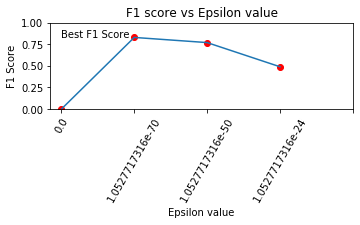

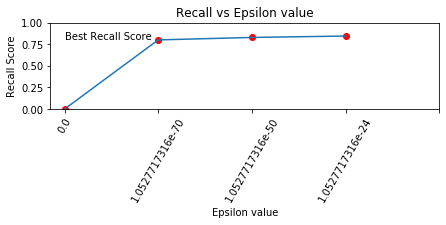

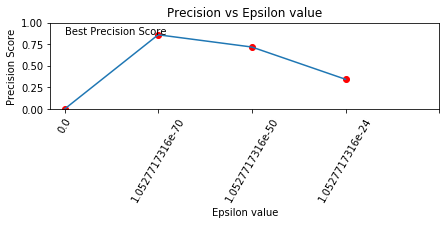

In [33]:
fscore, ep = selectThresholdByCV(p_cv,train_cv_y)

In [34]:
predictions = (p_test < ep)
Recall = recall_score(train_test_y, predictions, average = "binary")    
Precision = precision_score(train_test_y, predictions, average = "binary")
F1score = f1_score(train_test_y, predictions, average = "binary")    
print ('F1 score , Recall and Precision for Test dataset')
print ('Best F1 Score %f' %F1score)
print ('Best Recall Score %f' %Recall)
print ('Best Precision Score %f' %Precision)

F1 score , Recall and Precision for Test dataset
Best F1 Score 0.767816
Best Recall Score 0.681633
Best Precision Score 0.878947


Text(0.5, 1.0, 'Anomalies(in red) vs Predicted Anomalies(in Green)')

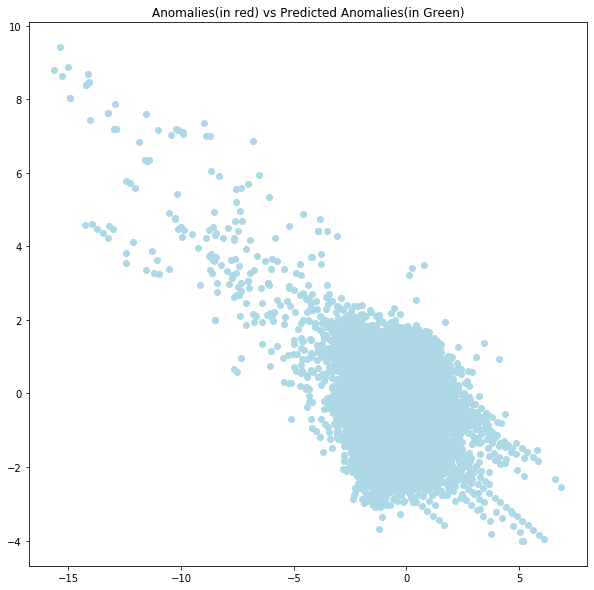

In [35]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(train_test['V14'],train_test['V11'],marker="o", color="lightBlue")
ax.set_title('Anomalies(in red) vs Predicted Anomalies(in Green)')


In [36]:
import time
from sklearn.manifold import TSNE
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(train_test.values)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 57107 samples in 0.072s...
[t-SNE] Computed neighbors for 57107 samples in 33.161s...
[t-SNE] Computed conditional probabilities for sample 1000 / 57107
[t-SNE] Computed conditional probabilities for sample 2000 / 57107
[t-SNE] Computed conditional probabilities for sample 3000 / 57107
[t-SNE] Computed conditional probabilities for sample 4000 / 57107
[t-SNE] Computed conditional probabilities for sample 5000 / 57107
[t-SNE] Computed conditional probabilities for sample 6000 / 57107
[t-SNE] Computed conditional probabilities for sample 7000 / 57107
[t-SNE] Computed conditional probabilities for sample 8000 / 57107
[t-SNE] Computed conditional probabilities for sample 9000 / 57107
[t-SNE] Computed conditional probabilities for sample 10000 / 57107
[t-SNE] Computed conditional probabilities for sample 11000 / 57107
[t-SNE] Computed conditional probabilities for sample 12000 / 57107
[t-SNE] Computed conditional probabilities for s

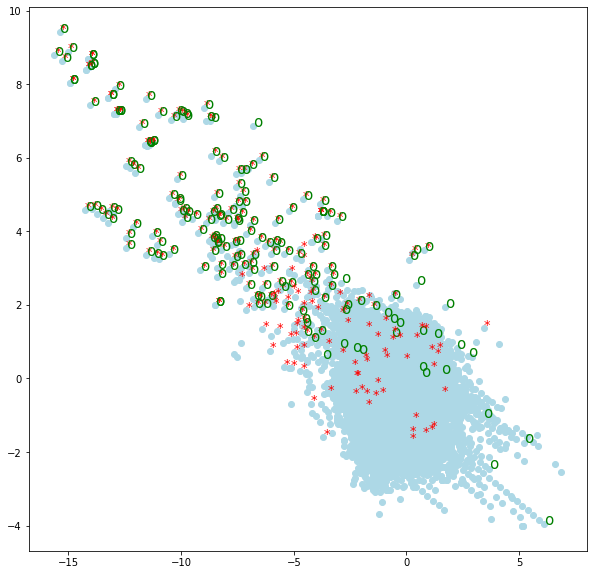

In [37]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(train_test['V14'],train_test['V11'],marker="o", color="lightBlue")
# ax.set_title('Anomalies(in red) vs Predicted Anomalies(in Green)')

for i, txt in enumerate(train_test['V14'].index):
       if train_test_y.loc[txt] == 1 :
            ax.annotate('*', (train_test['V14'].loc[txt],train_test['V11'].loc[txt]),fontsize=13,color='Red')
       if predictions[i] == True :
            ax.annotate('o', (train_test['V14'].loc[txt],train_test['V11'].loc[txt]),fontsize=15,color='Green')


In [38]:
len(train_test.values)

57107

In [39]:
len(tsne_results)

57107

In [40]:
train_test['resx'] = tsne_results[:,0]
train_test['resy'] = tsne_results[:,1]
train_test['y'] = [int(i) for i in predictions] 
#train_test.reset_index(inplace=True)

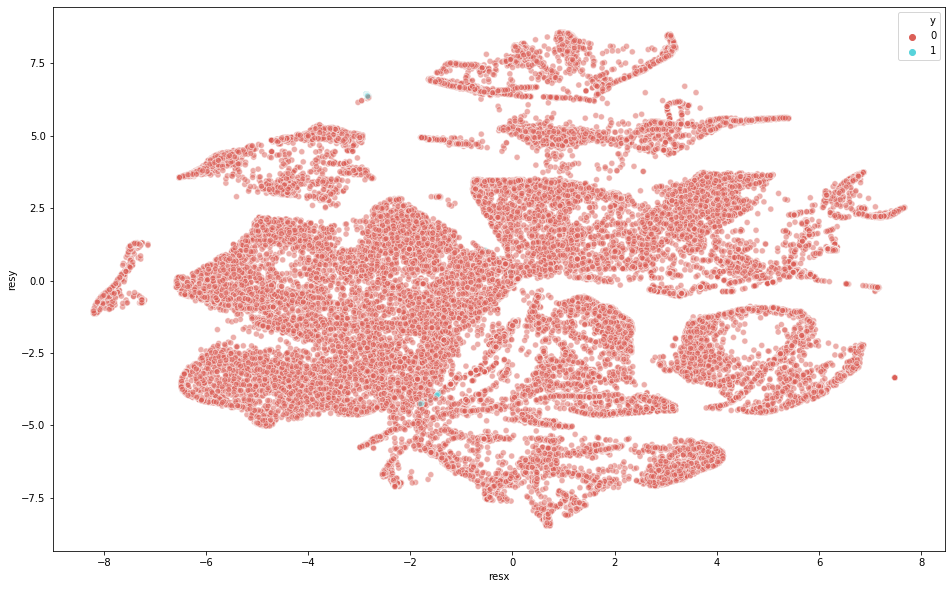

In [41]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="resx", y="resy",
    hue="y",
    palette=sns.color_palette("hls", 2),
    data=train_test,
    legend="full",
    alpha=0.5
)

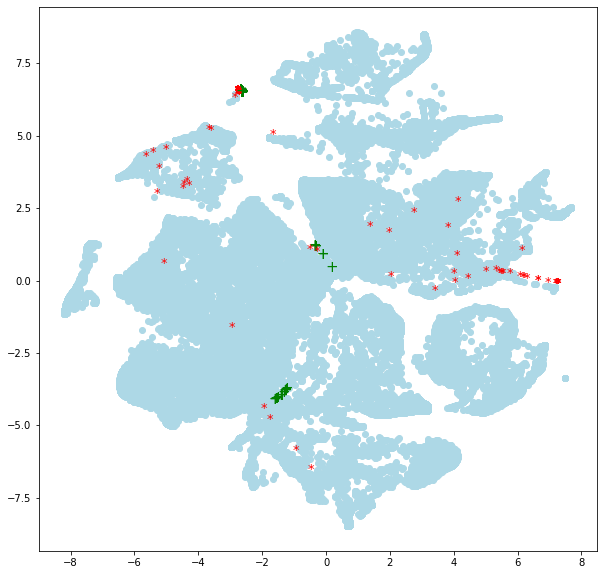

In [42]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(train_test['resx'],train_test['resy'],marker="o", color="lightBlue")
# ax.set_title('Anomalies(in red) vs Predicted Anomalies(in Green)')

for i, txt in enumerate(train_test['resx'].index):
       if train_test_y.loc[txt] == 1 :
            ax.annotate('*', (train_test['resx'].loc[txt],train_test['resy'].loc[txt]),fontsize=13,color='Red')
       if predictions[i] == True :
            ax.annotate('+', (train_test['resx'].loc[txt],train_test['resy'].loc[txt]),fontsize=15,color='Green')